In [1]:
from utils.audio_dataset_utils import train_val_dataset
from network_models.soundsream_models_and_utils.ss_model_dim_red import SSDimRedModel
from network_models.soundsream_models_and_utils.ss_model_conv import SSConvModel3Sec
from network_models.soundsream_models_and_utils.ss_encoded_dataset import ss_encoded_dataset_full
import torch
from torch.utils.data import DataLoader

batch_size = 6

data_set = ss_encoded_dataset_full(
    csvPath="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/allEncodings_version0_12_1.pkl",
    device="cuda")

modelDimRed = SSDimRedModel(eval_mode=True).cuda()
modelConv = SSConvModel3Sec(xSize=512, ySize=175, eval_mode=True).cuda()

trainDS, testDs = train_val_dataset(data_set, val_split=0.1, seed=100)
modelConv.load_state_dict(torch.load("../content/soundstream/experiments/experiment_v_12_1_NR3_relu/Run_Nr_0/conv/emo_reco_best_ep852_acc_75.pth"))
modelDimRed.load_state_dict(torch.load("../content/soundstream/experiments/experiment_v_12_1_NR3_relu/Run_Nr_0/dimred/emo_reco_best_ep824_acc_70.pth"))

2023-02-20 16:16:44.523682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 16:16:45.336481: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-20 16:16:45.336591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-20 16:16:45.336599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<All keys matched successfully>

In [2]:
import pandas as pd
import numpy as np
from numpy import ndarray
json_path ="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/"

def generateParameters(device, model, dataset, labels):
    loader = DataLoader(dataset, shuffle=False, batch_size=1)
    d ={}

    for label in labels:
        d.update({label: []})

    with torch.no_grad():
        for batch, (X, z) in enumerate(loader):
            X, z = X.to(device),  z.to(device)
            dims, pred = model(X, return_with_dims= True)
            label = data_set.encoded_dataset.label_list[z[0].nonzero().cpu().numpy()[0][0]]
            dims = dims.cpu().numpy()[0]
            d[label].append(dims)
            if batch % 500 == 0:
                print(f"{batch*batch_size} of {len(dataset)}")
    return d

def genAvgAndVarByLabel(data: list[ndarray[float]], labelList):
    d = pd.DataFrame()
    for label in labelList:
        mean = np.round(np.asarray(data[label]).mean(keepdims=True, axis=0), 2)
        var = np.round(np.asarray(data[label]).var(keepdims=True, axis=0), 2)
        d[label] = pd.Series([mean[0], var[0]], index=["mean", "var"])
        #d.update({label : pd.Series([mean, var], index=["mean", "var"])})
        #d.update({label : pd.Series([mean, var], index=["mean", "var"])})

    return d

def genAvgFullByLabel(fulldata: list[dict], label_list, modelNameList):
    fullDict = {}
    for model in range(len(modelNameList)):
        fullDict.update({modelNameList[model]: genAvgAndVarByLabel(fulldata[model], label_list)})
    return fullDict

def genAvgAndVar(data: list[list[ndarray[float]]], modelNameList):
    d = {}
    for i in range(len(modelNameList)):
        mean = np.mean(np.asarray(data[i]), axis=0)
        var = np.var(np.asarray(data[i]), axis=0)
        d.update({modelNameList[i] : pd.Series([mean, var], index=["mean", "var"])})
    return d

def genAvgFull(fulldata: list[dict], label_list, modelNameList):
    fullDict = {}
    for label in label_list:
        fullDict.update({label: genAvgAndVar([fd[label] for fd in fulldata], modelNameList)})
    return fullDict

def write_latex(fileName, string):
    print(f"writing: {string} \n to {json_path+fileName}.txt")
    file = open(json_path+f"{fileName}.txt", "w")
    file.write(string)
    file.close()

In [3]:
arra = generateParameters("cuda", modelConv, testDs, data_set.encoded_dataset.label_list)
arra_dr = generateParameters("cuda", modelDimRed, testDs, data_set.encoded_dataset.label_list)


0 of 610
3000 of 610
0 of 610
3000 of 610


In [ ]:
#asaa = pd.DataFrame(genAvgFull([arra, arra_dr], data_set.encoded_dataset.label_list ,["conv", "dimred"]))
asaa = genAvgFullByLabel([arra, arra_dr], data_set.encoded_dataset.label_list ,["conv", "dimred"])

write_latex("conv_mean_var" ,asaa["conv"].T.to_latex(float_format="{{:0.2f}}"))
write_latex("dimred_mean_var" ,asaa["dimred"].T.to_latex(float_format="{{:0.2f}}"))
#asaa["conv"].to_latex()

In [47]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns



def show_bars(predictions, label_list, color="r", title_string = ""):

    fig = plt.figure(constrained_layout=True , figsize=(20, 50))
    fig.suptitle(title_string)

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=7, ncols=1)
    for label in range(len(label_list)):

        axs = subfigs[label].subplots(nrows=1, ncols=4)

        subfigs[label].suptitle(f'{label_list[label]}', fontsize=19)
        sns.histplot([item[0] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[0], kde=True, kde_kws={"cut": 3}, stat="density")
        sns.histplot([item[1] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[1], kde=True, kde_kws={"cut": 3}, stat="density")
        sns.histplot([item[2] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[2], kde=True, kde_kws={"cut": 3}, stat="density")
        sns.histplot([item[3] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[3], kde=True, kde_kws={"cut": 3}, stat="density")

    #for row, subfig in enumerate(subfigs):
    #    subfig.suptitle(f'Subfigure title {row}')

    #    axs = subfig.subplots(nrows=1, ncols=4)
    #
    #    #for col, ax in enumerate(axs):
    #    #    ax.plot()
    #    #    ax.set_title(f'Plot title {col}')

    #for label in range(len(label_list)):
    #   #print(f"--------------------------------------------- {label} --------------------------------------------")

    #   #sns.displot(arra[label], bins=100, color="g", kde=True)

    #   sns.histplot([item[0] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][0], kde=True, kde_kws={"cut": 3}, stat="density")
    #   sns.histplot([item[1] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][1], kde=True, kde_kws={"cut": 3}, stat="density")
    #   sns.histplot([item[2] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][2], kde=True, kde_kws={"cut": 3}, stat="density")
    #   sns.histplot([item[3] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][3], kde=True, kde_kws={"cut": 3}, stat="density")

    #fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(50, 50))
    ##fig.suptitle(f'{label}', fontsize=16)
    #for label in range(len(label_list)):
    #    #print(f"--------------------------------------------- {label} --------------------------------------------")
#
    #    #sns.displot(arra[label], bins=100, color="g", kde=True)
#
    #    sns.histplot([item[0] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][0], kde=True, kde_kws={"cut": 3}, stat="density")
    #    sns.histplot([item[1] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][1], kde=True, kde_kws={"cut": 3}, stat="density")
    #    sns.histplot([item[2] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][2], kde=True, kde_kws={"cut": 3}, stat="density")
    #    sns.histplot([item[3] for item in predictions[label_list[label]]], bins=25, color=color, ax=axs[label][3], kde=True, kde_kws={"cut": 3}, stat="density")
#
    #plt.show()

# sns.displot(arra["angry"], bins=100, color="g", kde=True)
# plt.show()


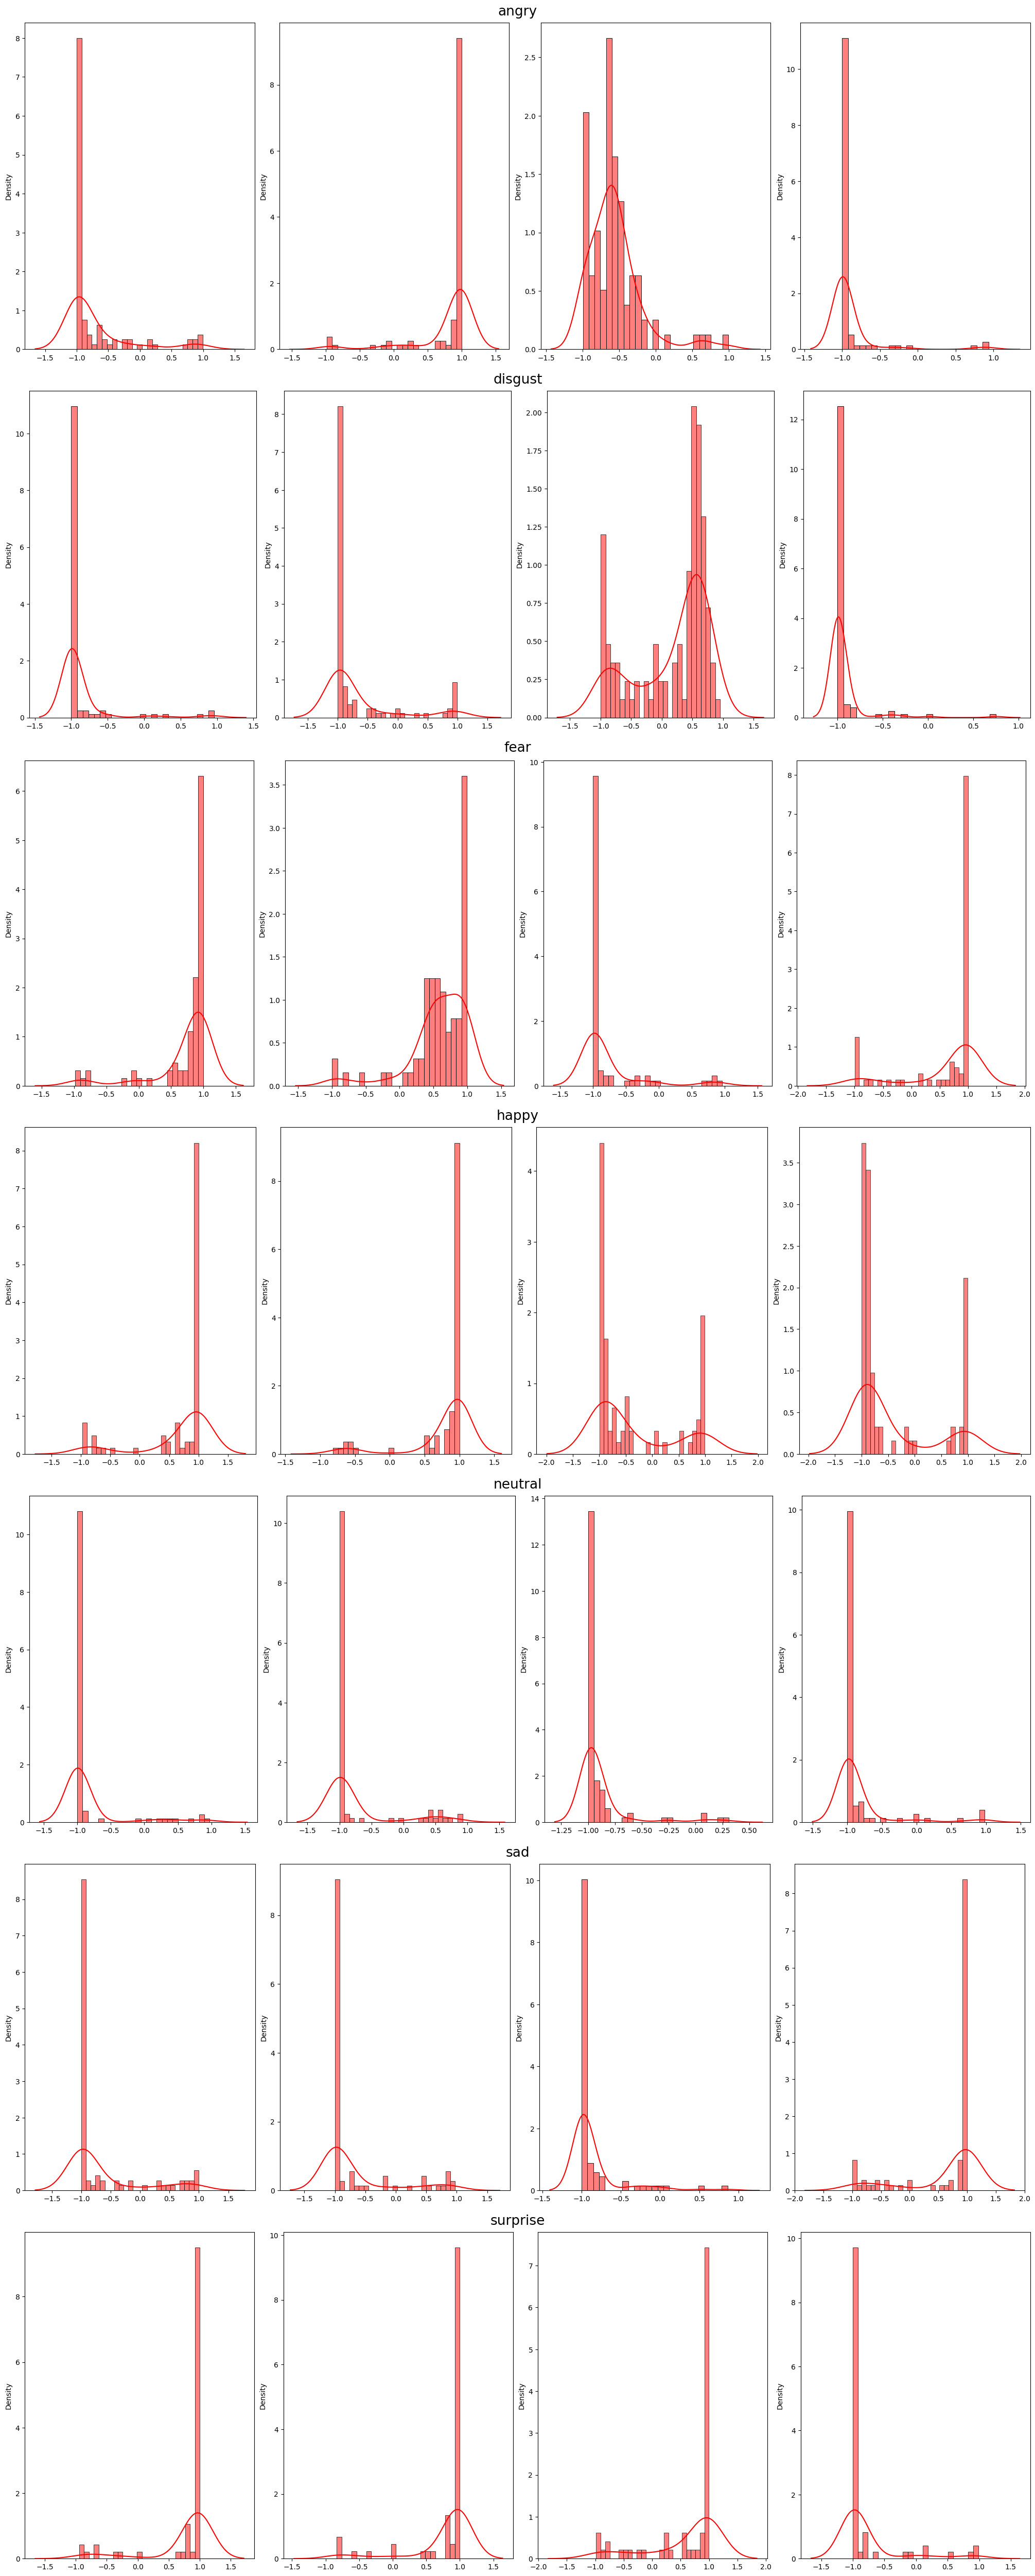

In [48]:
show_bars(arra, data_set.encoded_dataset.label_list)